In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [85]:
df = pd.read_csv('estadisticas_fantasy.csv')
print(df)

     Unnamed: 0          Nombre Posición        Equipo  Puntos  \
0             0     Lewandowski       DL  FC Barcelona     146   
1             1        Raphinha       DL  FC Barcelona     143   
2             2    Lamine Yamal       DL  FC Barcelona     137   
3             3    Vinícius Jr.       DL   Real Madrid     118   
4             4          Mbappe       DL   Real Madrid     102   
..          ...             ...      ...           ...     ...   
585         585         Vallejo       DF   Real Madrid      -1   
586         586          Adrián       PO    Real Betis      -2   
587         587  Rodrigo Abajas       DF   Valencia CF      -2   
588         588     Juan Carlos       PO        Girona      -3   
589         589        R Chasco       DF    Valladolid      -3   

     Media Puntos Relevo  Puntos Relevo Precio Actual Precio Inicial  Media  \
0                   2.85             37   127.371.980    127.397.088  11.23   
1                   3.23             42   125.574

In [86]:
### EDA ###

In [87]:
print("num_atributs: ", len(df.keys()))
nan_columns = df.columns[df.isna().sum()>0].tolist()
print("NaNs: ", nan_columns)
print("num nans", df.isna().sum().sum())
print("Describe\n", df.describe())
print("\n\ninfo:\n", df.info())
print("\n\nnunique:\n", df.nunique())

num_atributs:  31
NaNs:  []
num nans 0
Describe
        Unnamed: 0      Puntos  Media Puntos Relevo  Puntos Relevo       Media  \
count  590.000000  590.000000           590.000000     590.000000  590.000000   
mean   294.500000   27.794915             0.893814       9.661017    2.543678   
std    170.462606   25.861069             0.795729       9.135669    2.227177   
min      0.000000   -3.000000             0.000000       0.000000   -0.330000   
25%    147.250000    7.250000             0.000000       0.000000    0.730000   
50%    294.500000   21.000000             0.750000       8.000000    2.180000   
75%    441.750000   46.000000             1.400000      15.000000    4.000000   
max    589.000000  146.000000             3.580000      43.000000   11.420000   

         Partidos      Minutos       Goles  Asistencias  Asistencias sin Gol  \
count  590.000000   590.000000  590.000000   590.000000           590.000000   
mean     9.001695   399.581356    0.479661     0.362712      

In [88]:
df.rename(columns={'Unnamed: 0': 'ID_jugador'}, inplace=True)

df['Precio Actual'] = df['Precio Actual'].str.replace('.','')
df['Precio Inicial'] = df['Precio Inicial'].str.replace('.','')

df['Precio Actual'] = df['Precio Actual'].astype(int)
df['Precio Inicial'] = df['Precio Inicial'].astype(int)
df['Diferencia Preu'] = df['Precio Actual'] - df['Precio Inicial']

df = df[df['Posición'] != 'DT']
df.drop(columns=['Nombre'], inplace=True)
df.drop(columns=['ID_jugador'], inplace=True)
df.drop(columns=['Precio Inicial'], inplace=True)
df.drop(columns=['Precio Actual'], inplace=True)

le = LabelEncoder()
df['Posición'] = le.fit_transform(df['Posición'])
df['Equipo'] = le.fit_transform(df['Equipo'])


C:\Users\santi\AppData\Local\Temp\ipykernel_14636\2038030753.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Precio Actual'] = df['Precio Actual'].str.replace('.','')
C:\Users\santi\AppData\Local\Temp\ipykernel_14636\2038030753.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Precio Inicial'] = df['Precio Inicial'].str.replace('.','')


In [89]:
### CORRELATIONS ###

Text(0.5, 1.0, 'Correlation Matrix')

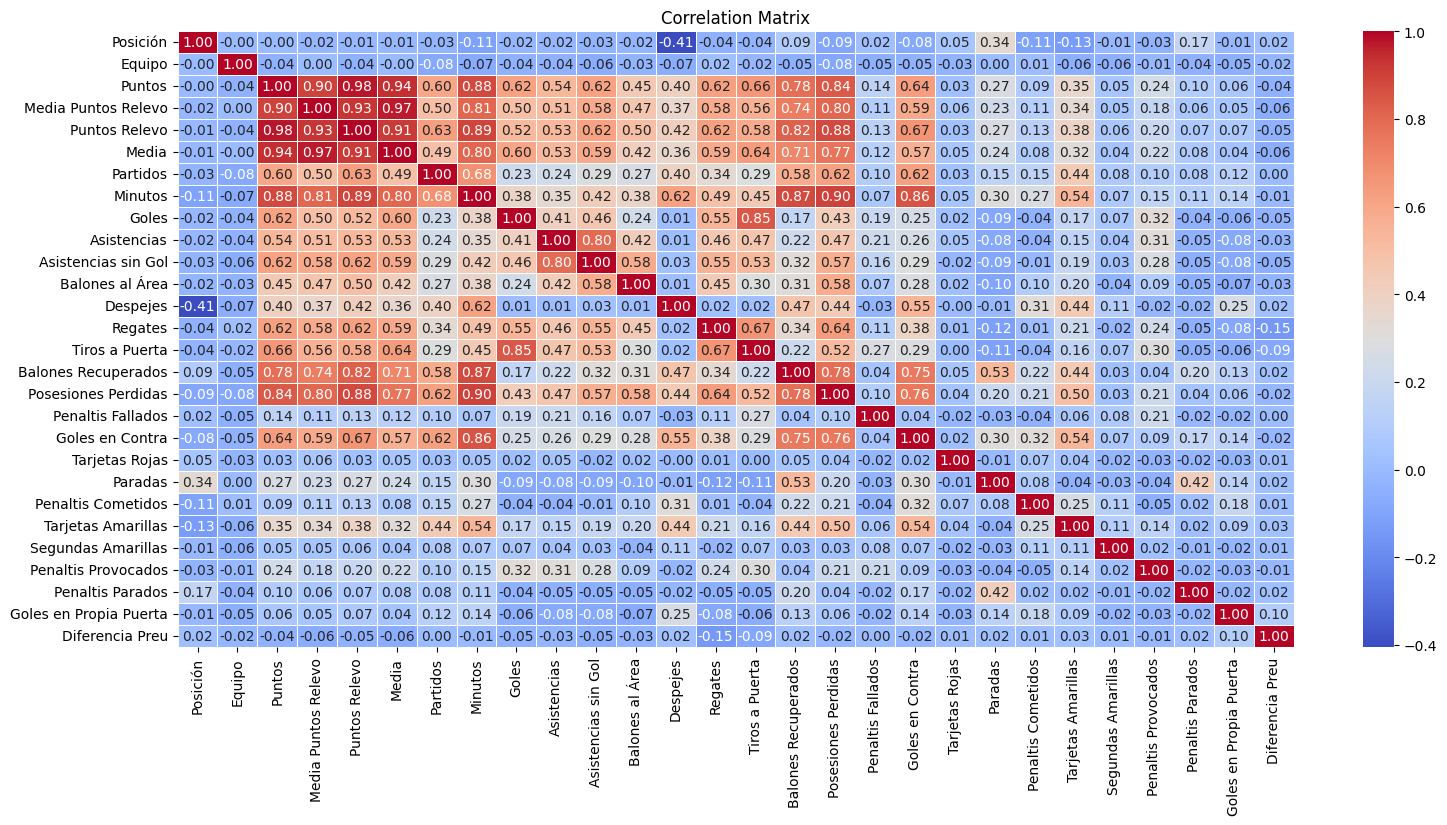

In [90]:
corr_matrix = df.corr()
#corr_preu_actual = corr_matrix[['Precio Actual']]

plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')

#plt.figure(figsize=(1,8))
#sns.heatmap(corr_preu_actual, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
#plt.title('Correlation Matrix')
#plt.show()

In [92]:
target_att = 'Diferencia Preu'

attributes = [k for k in df.keys() if k!= target_att]
X = df[attributes].to_numpy()
y = df[[target_att]].to_numpy()

#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_norm = sc.fit_transform(X)
#y_norm = sc.fit_transform(y)

X_train, X_test, y_train , y_test = train_test_split(X,y,test_size = 0.2, random_state=42)


In [93]:
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

r2_test = r2_score(y_test,y_pred)
r2_train = r2_score(y_train,y_pred_train)
print (r2_train,r2_test)


0.1364963496924474 0.010428484772273539


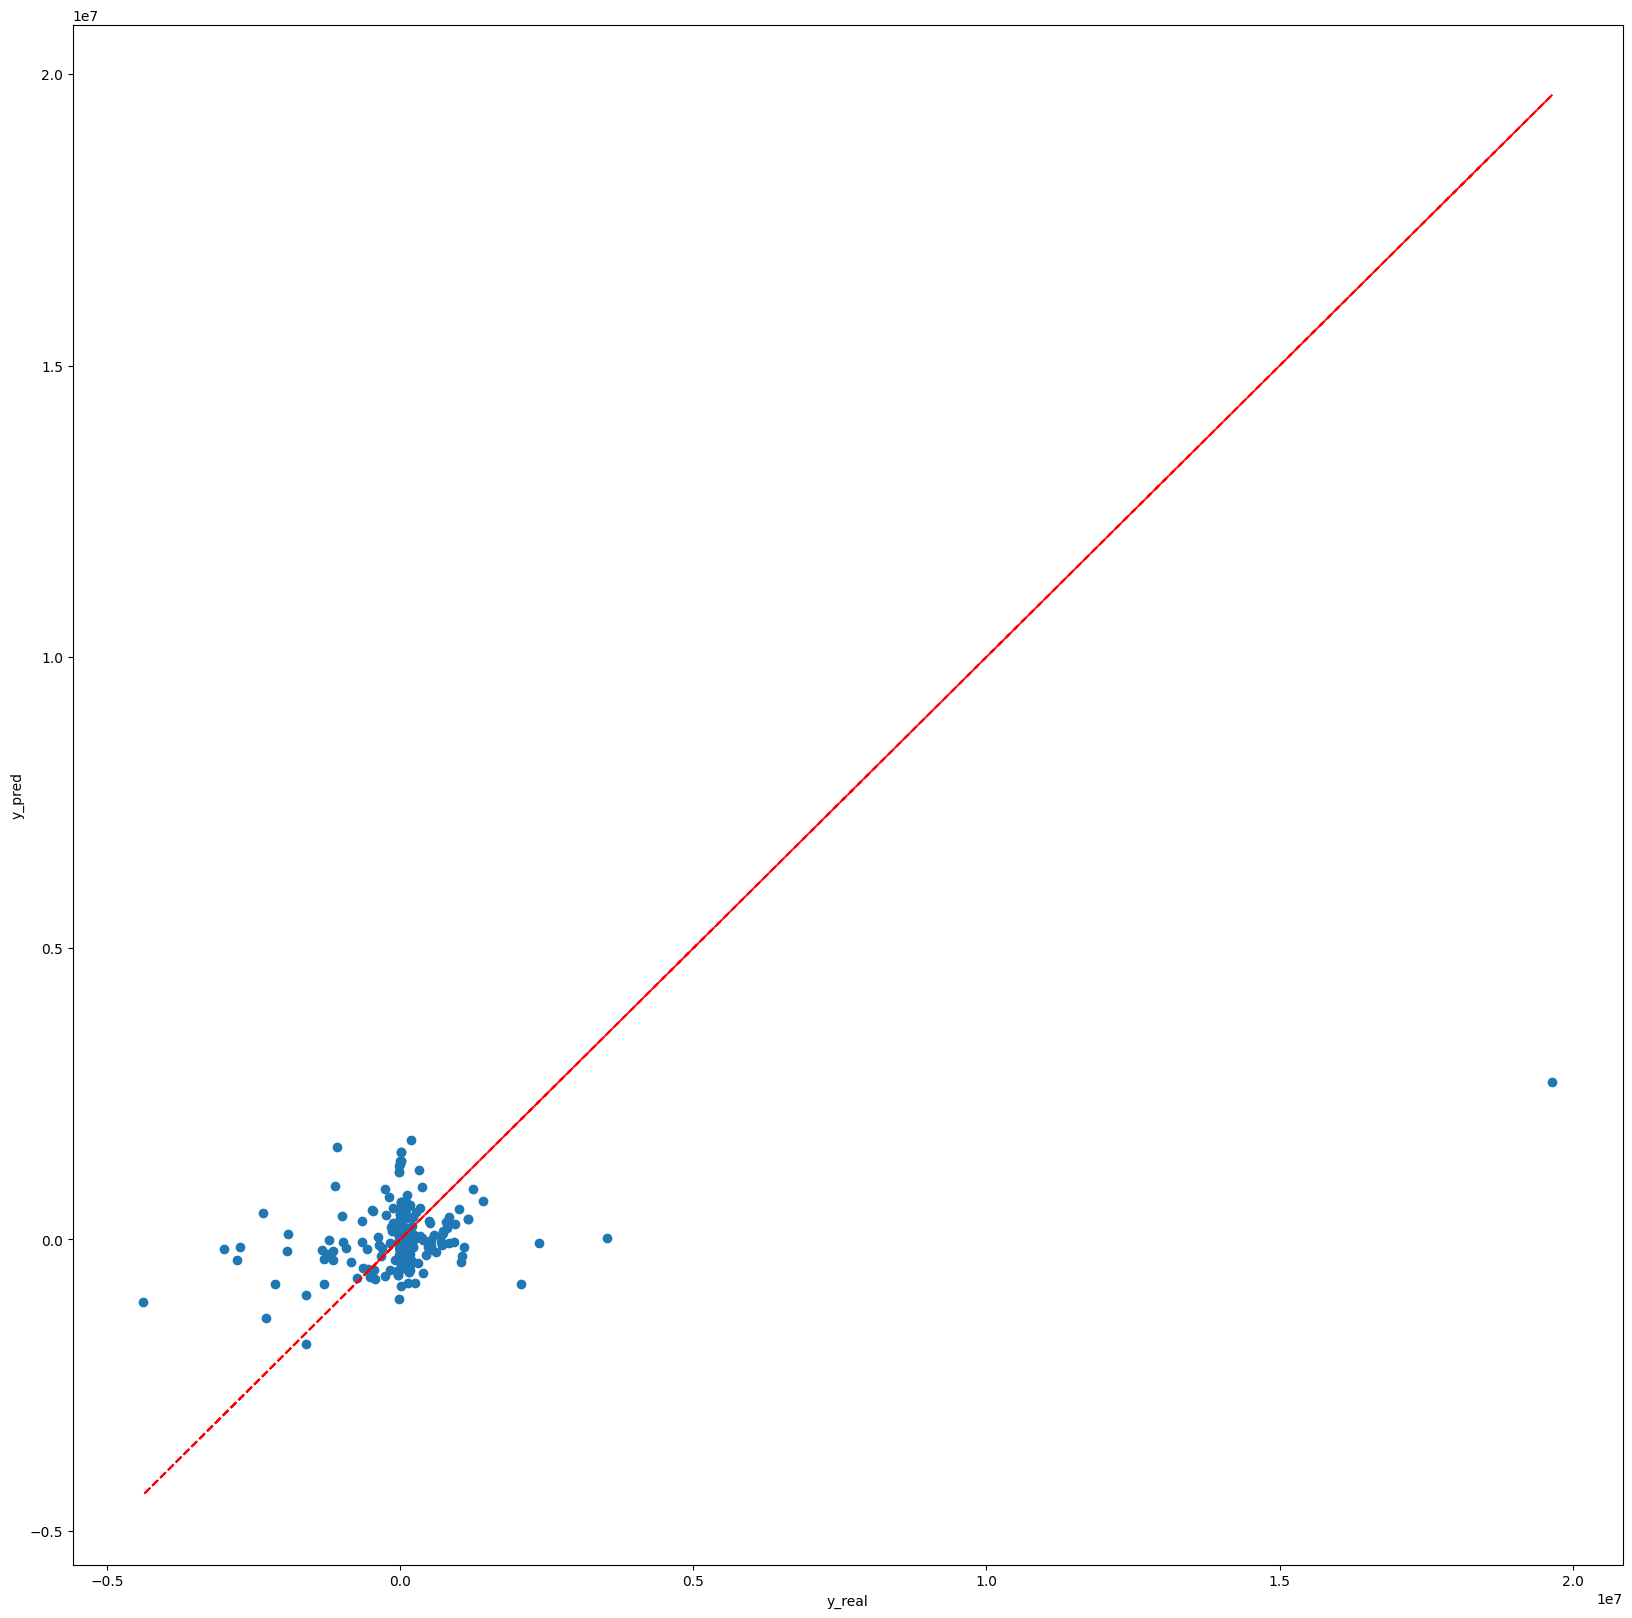

"\nplt.scatter(y_train,y_pred_train-y_train)\nplt.xlabel('y_real')\nplt.ylabel('error')\nplt.show()\n\nplt.scatter(y_train,abs(y_pred_train-y_train))\nplt.xlabel('y_real')\nplt.ylabel('MAE')\nplt.show()\n\n\nplt.scatter(y_train,abs(y_pred_train-y_train)/y_train)\nplt.xlabel('y_real')\nplt.ylabel('MAPE')\nplt.show()\n"

In [94]:
plt.figure(figsize=(20,20))
y_train = np.array(y_train).flatten()
y_pred_train = y_pred_train.flatten()
plt.scatter(y_train ,y_pred_train)
plt.plot(y_train,y_train,'--',c = 'red')
plt.xlabel('y_real')
plt.ylabel('y_pred')
plt.show()
'''
plt.scatter(y_train,y_pred_train-y_train)
plt.xlabel('y_real')
plt.ylabel('error')
plt.show()

plt.scatter(y_train,abs(y_pred_train-y_train))
plt.xlabel('y_real')
plt.ylabel('MAE')
plt.show()


plt.scatter(y_train,abs(y_pred_train-y_train)/y_train)
plt.xlabel('y_real')
plt.ylabel('MAPE')
plt.show()
'''

(452, 1)
(452, 1)


TypeError: unhashable type: 'numpy.ndarray'

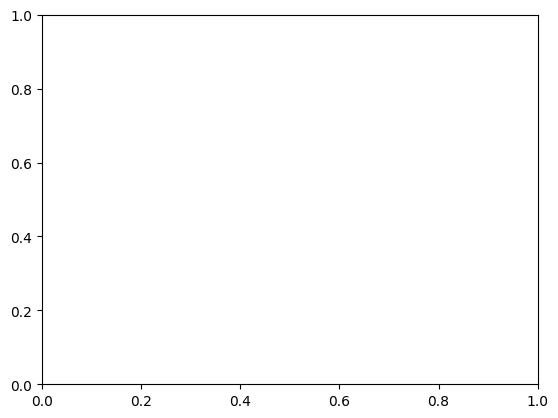

In [ ]:
plt.figure(figsize=(20,20))
y_train = np.array(y_train).flatten()
y_pred_train = y_pred_train.flatten()
plt.scatter(y_train,y_pred_train, norm='Normalize')
plt.plot(y_train,y_train,'--',c = 'red')
plt.xlabel('y_real')
plt.ylabel('y_pred')
plt.show()

plt.scatter(y_train,y_pred_train-y_train)
plt.xlabel('y_real')
plt.ylabel('error')
plt.show()

plt.scatter(y_train,abs(y_pred_train-y_train))
plt.xlabel('y_real')
plt.ylabel('MAE')
plt.show()


plt.scatter(y_train,abs(y_pred_train-y_train)/y_train)
plt.xlabel('y_real')
plt.ylabel('MAPE')
plt.show()